In [5]:
import re
import numpy as np
import pandas as  pd
from pprint import pprint# Gensim
import gensim
import gensim.corpora as corpora
import gensim.models as genmodels
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pickle
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')


#stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [7]:
df = pickle.load(open("../data/merged_hotel_data.pkl", "rb"))
df=df.replace(r'^\s*$', np.nan, regex=True)
print(df.shape)
#df.head()


(76536, 30)


In [9]:
default_comments=["Exceptional", "Very Good", "Wonderful", "Good", "Pleasant","Fair", "Disappointing","Bad", "Poor",
                 "Excellent", "Very Poor", "Okay", "Great","Very Good","Ok"]

pattern = '|'.join(default_comments)
df_reviews_sr=df[["short_review"]].dropna()
df_reviews_sr=df_reviews_sr[~df_reviews_sr.short_review.str.contains(pattern)]
df_reviews_sr

,short_review
0,Ilike The place
1,average
2,okay
6,Practically okay
7,"convenient location, price is good"
...,...
76447,Thank you sa pag stay ko sa hotel 88 courtyard
76448,Wifi很差！
76449,Anche no!!
76459,Can I disparage the 88 to discourage people f...


In [94]:
# Convert to list 
data = df_reviews_sr.short_review.values.tolist()  
# # Remove Emails 
# data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]  
# # Remove new line characters 
# data = [re.sub('\s+', ' ', sent) for sent in data]  
# # Remove distracting single quotes 
# data = [re.sub("\'", "", sent) for sent in data]
# #Remove \n
# data = [re.sub("\n", "", sent) for sent in data]
# data = [re.sub("(Image courtesy: )", "", sent) for sent in data]
# #Remove links
# data = [re.sub(r'http\S+', '', sent) for sent in data]
display(len(data))
print(data[8])

17045

 good 


### Tokenization

In [95]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))            #deacc=True removes punctuations

data_words = list(sent_to_words(data))
print(data_words[:9]) 

[['ilike', 'the', 'place'], ['average'], ['okay'], ['practically', 'okay'], ['convenient', 'location', 'price', 'is', 'good'], ['been', 'visited', 'many', 'countries', 'for', 'tour', 'and', 'your', 'hotel', 'is', 'very', 'nice', 'place', 'to', 'stay', 'thank', 'you'], ['peaceful'], ['practicality', 'yet', 'comfty'], ['good']]


### Building the bigram and trigram Models

In [96]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)


In [97]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[8]]])

['good']


### Define function for stopwords, bigrams, trigrams and lemmatization

In [98]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [99]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
data_words_trigrams = make_trigrams(data_words_nostops)


In [100]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en

#nlp = spacy.load('en_core_web_lg')
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])


# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized_bi = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
data_lemmatized_tri = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized_bi[-1])

['nice', 'hotel', 'great', 'staff', 'thank']


In [101]:
len(data_lemmatized_bi)

17045

In [102]:
id2word_bi = corpora.Dictionary(data_lemmatized_bi)  
id2word_tri = corpora.Dictionary(data_lemmatized_tri)  

In [103]:
texts_bi = data_lemmatized_bi
texts_tri = data_lemmatized_tri

In [104]:
# Term Document Frequency 
corpus_bi = [id2word_bi.doc2bow(text) for text in texts_bi]  
corpus_tri = [id2word_tri.doc2bow(text) for text in texts_tri]  

In [47]:
# View 
print(corpus_bi[:8])

[[(0, 1)], [(1, 1)], [], [(2, 1)], [(3, 1)], [(3, 1)], [(4, 1), (5, 1)], [(3, 1), (6, 1), (7, 1), (8, 1)]]


In [105]:
[[(id2word_bi[id], freq) for id, freq in cp] for cp in corpus_bi[:1]]
[[(id2word_tri[id], freq) for id, freq in cp] for cp in corpus_tri[:1]]

[[('place', 1)]]

<AxesSubplot: ylabel='word'>

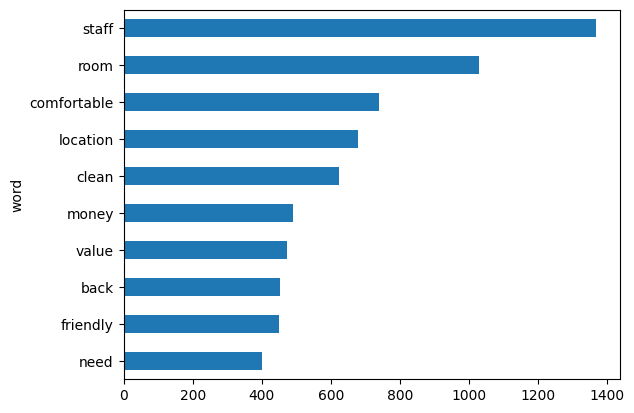

In [114]:
bow=[[(id2word_tri[id], freq) for id, freq in cp] for cp in corpus_tri]
flat_list = [item for sublist in bow for item in sublist]


no_value_words=["stay","good","hotel","place","nice","great"]

df_bow = pd.DataFrame(flat_list, columns = ['word', 'count'])
df_bow=df_bow[~df_bow.word.str.contains('|'.join(no_value_words))] 
df_bow.groupby("word")["count"].sum().sort_values(ascending=True).tail(10).plot.barh()

### LSI & LDA Model

In [22]:
def model_competition(corpus,id2word,data_lemmatized):
    random_state = 100
    for_framing = []
    
    algo_names = ["LDA Model","LSI Model",]
    algorithms = [genmodels.ldamodel.LdaModel,genmodels.lsimodel.
                  LsiModel]
    
    for algo_name, algorithm in zip(algo_names, algorithms):
        for k in range(1, 11):
            if algo_name == 'LDA Model':
                model = algorithm(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        
                perplexity = model.log_perplexity(corpus)
                coherence_model = CoherenceModel(model=model, texts=data_lemmatized, 
                               dictionary=id2word, coherence='c_v')
                coherence = coherence_model.get_coherence()
            if algo_name == 'LSI Model':
                model = algorithm(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=k,
                                  chunksize=100)
        
                coherence_model = CoherenceModel(model=model, texts=data_lemmatized, 
                               dictionary=id2word, coherence='c_v')
                coherence = coherence_model.get_coherence()
        
            data_row = {
                'model': algo_name,
                'topic count' : k,
                'coherence' : coherence
            }
            for_framing.append(data_row)
        
    return pd.DataFrame(for_framing)
        
        
    

In [ ]:
bigram_dataframe = model_competition(corpus_bi,id2word_bi,data_lemmatized_bi)

In [58]:
bigram_dataframe.sort_values(by=['coherence'],ascending=False).head(1)

,model,topic count,coherence
8,LDA Model,9,0.604526


In [59]:
trigram_dataframe = model_competition(corpus_tri,id2word_tri,data_lemmatized_tri)

In [60]:
trigram_dataframe.sort_values(by=['coherence'],ascending=False).head(1)

,model,topic count,coherence
8,LDA Model,9,0.604363


# HDP

In [19]:
hdpmodel =  gensim.models.hdpmodel.HdpModel(corpus=corpus_bi, id2word=id2word_bi)
coherence_model_hdpmodel = CoherenceModel(model=hdpmodel, texts=data_lemmatized_bi, dictionary=id2word_bi, coherence='c_v')
coherence_hdpmodel = coherence_model_hdpmodel.get_coherence()
print('\nCoherence Score: ', coherence_hdpmodel)


Coherence Score:  0.543526652939898


In [21]:
hdpmodel.show_topics()

[(0,
  '0.015*datum + 0.010*model + 0.009*use + 0.005*data + 0.005*time + 0.005*learn + 0.005*make + 0.005*also + 0.004*image + 0.004*dataset + 0.004*need + 0.004*create + 0.004*value + 0.004*learning + 0.004*get + 0.004*function + 0.004*feature + 0.004*code + 0.004*work + 0.003*example'),
 (1,
  '0.019*datum + 0.009*model + 0.009*data + 0.007*use + 0.007*science + 0.006*learn + 0.006*work + 0.005*time + 0.005*value + 0.004*get + 0.004*make + 0.004*learning + 0.004*project + 0.004*machine + 0.004*good + 0.004*well + 0.004*need + 0.003*find + 0.003*also + 0.003*feature'),
 (2,
  '0.014*datum + 0.010*model + 0.009*use + 0.006*learn + 0.006*learning + 0.006*data + 0.005*function + 0.005*value + 0.005*time + 0.005*image + 0.004*create + 0.004*feature + 0.004*also + 0.004*dataset + 0.004*let + 0.004*make + 0.004*work + 0.004*see + 0.003*need + 0.003*machine'),
 (3,
  '0.009*datum + 0.007*use + 0.006*time + 0.006*code + 0.005*value + 0.004*function + 0.004*create + 0.004*need + 0.004*get + 0

In [22]:
hdpmodel_tri =  gensim.models.hdpmodel.HdpModel(corpus=corpus_tri, id2word=id2word_tri)
coherence_model_hdpmodel_tri = CoherenceModel(model=hdpmodel_tri, texts=data_lemmatized_tri, dictionary=id2word_tri, coherence='c_v')
coherence_hdpmodel_tri = coherence_model_hdpmodel_tri.get_coherence()
print('\nCoherence Score: ', coherence_hdpmodel_tri)


Coherence Score:  0.5348782847089283


In [23]:
hdpmodel_tri.show_topics()

[(0,
  '0.017*datum + 0.010*model + 0.009*use + 0.007*data + 0.006*time + 0.006*learn + 0.005*value + 0.005*learning + 0.004*make + 0.004*work + 0.004*also + 0.004*code + 0.004*image + 0.004*function + 0.004*need + 0.004*get + 0.004*science + 0.004*example + 0.004*well + 0.004*feature'),
 (1,
  '0.008*model + 0.008*use + 0.007*datum + 0.006*python + 0.005*dataset + 0.005*user + 0.005*function + 0.005*create + 0.004*new + 0.004*project + 0.004*method + 0.004*want + 0.004*get + 0.004*see + 0.004*time + 0.004*need + 0.004*make + 0.003*also + 0.003*learn + 0.003*work'),
 (2,
  '0.011*model + 0.010*datum + 0.007*use + 0.005*value + 0.005*image + 0.004*word + 0.004*make + 0.004*work + 0.004*data + 0.004*training + 0.003*time + 0.003*learning + 0.003*learn + 0.003*well + 0.003*also + 0.003*feature + 0.003*number + 0.003*set + 0.003*good + 0.003*dataset'),
 (3,
  '0.015*datum + 0.008*data + 0.007*learn + 0.006*science + 0.005*work + 0.004*job + 0.004*get + 0.004*need + 0.004*use + 0.004*help +